<h1 align="center">CommonLit Readability Kaggle</h1>
<hr>

# Introduction
In this notebook I have tried a few NLP techniques which you can apply which will help you in solving any NLP problem.


<b>Objective:</b> The objective of this competition is to rate the complexity level of literary passages for grades 3-12 use.
<b>Dataset:</b> The dataset contains excerpts from several time periods and a wide range of reading ease scores.

<b>Columns of the train/test data-</b> 

* ```id``` - unique ID for excerpt
* ```url_legal``` - URL of source (blank in the test set)
* ```license``` - license of source material (blank in the test set)
* ```excerpt``` - text to predict reading ease of
* ```target``` - reading ease
* ```standard_error``` - measure of spread of scores among multiple raters for each excerpt (not included for test data)

# Table of Contents
<ul style="list-style-type:square">
    <li><a href="#1">Importing Libraries</a></li>
    <li><a href="#2">Reading the data</a></li>
    <li><a href="#3">Exploratory Data Analysis</a></li>
    <li><a href="#4">Data Preprocessing</a></li>
    <li><a href="#5">ML Models (Baseline)</a></li>
    <ul>
        <li><a href="#5.1">Linear Regression</a></li>
        <li><a href="#5.2">Ridge Regression</a></li>
        <li><a href="#5.3">Support Vector Regression</a></li>
        <li><a href="#5.4">Random Forest Regressor</a></li>
        <li><a href="#5.5">Gradient Boosting Regressor</a></li>
        <li><a href="#5.6">AdaBoost Regressor</a></li>
        <li><a href="#5.7">XGBoost Regressor</a></li>
    </ul>
    <li><a href="#6">DL Models (Baseline)</a></li>
    <ul>
        <li><a href="#6.1">Simple RNN</a></li>
        <li><a href="#6.2">LSTM</a></li>
        <li><a href="#6.3">Bidirectional RNN</a></li>
        <li><a href="#6.4">BERT</a></li>
    </ul>
</ul>

<a id='1'></a>
# Importing Libraries

In [1]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-dark')
import plotly.express as px
from textblob import TextBlob
from PIL import Image
import requests
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, SimpleRNN, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, SimpleRNN, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

<a id='2'></a>
# Reading the data

In [2]:
df = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

In [3]:
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2834 non-null   object 
 1   url_legal       830 non-null    object 
 2   license         830 non-null    object 
 3   excerpt         2834 non-null   object 
 4   target          2834 non-null   float64
 5   standard_error  2834 non-null   float64
dtypes: float64(2), object(4)
memory usage: 133.0+ KB


<a id='3'></a>
# Exploratory Data Analysis

### **First let us look the distribution of target.**

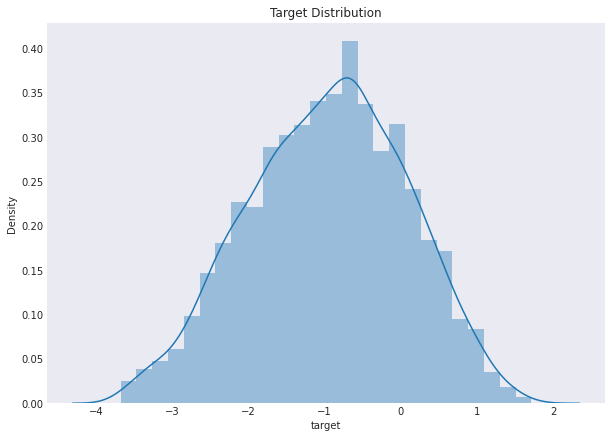

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

In [5]:
plt.figure(figsize=(10, 7))
sns.distplot(df['target'])
plt.title('Target Distribution')
plt.show()
df['target'].describe()

This shows that our data is normally distributed with mean=-0.959319 and standard deviation=1.033579.
The target ranges from -3.676268 to 1.711390 where target=-3.67 is the most difficult text and target=1.71 is the easiest.<br> **Let us also look the distribution of standard error.**

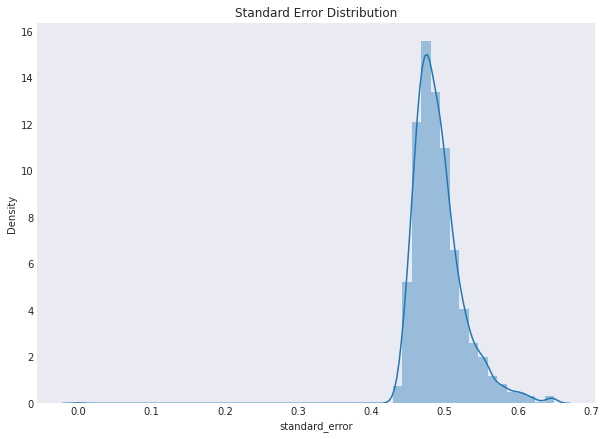

count    2834.000000
mean        0.491435
std         0.034818
min         0.000000
25%         0.468543
50%         0.484721
75%         0.506268
max         0.649671
Name: standard_error, dtype: float64

In [6]:
plt.figure(figsize=(10, 7))
sns.distplot(df['standard_error'])
plt.title('Standard Error Distribution')
plt.show()
df['standard_error'].describe()

The standard_error basically tells us the measure of spread of scores among the raters for each excerpt, that means each excerpt has been read by many different people and accordingly they have given their score and standard_error measures the difference. It means that lesser the standard_error, more precise the target value.  From the plot we can observe that it is very sqewed to the left. But we also have one outlier and where standard_error=0. This excerpt is considered as the reference except and all other excerpt are compared with this excerpt. 

In [7]:
df[df['standard_error']== 0]

,id,url_legal,license,excerpt,target,standard_error
106,436ce79fe,NaN,NaN,"The sun was shining in a cloudless sky, and no...",0.0,0.0


### **Let us also look at the relationship between target and standard_error.**

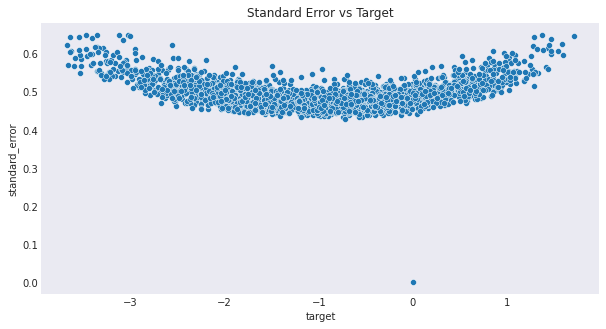

In [8]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='target', y='standard_error', data=df)
plt.title('Standard Error vs Target')
plt.show()

Although we can observe there is no linear relationship between target and standard_error. Still we can say that when the target value is very high or very low (i.e. excerpt is either very easy or very difficult) then the standard_error is high that means most of the raters disagreed.

### **Now let us get some insighsts from the "excerpt".**

First of all we will observe the most common words in the excerpt.
For that we will first clean the data and will also remove the stopwords. We will store this in a new column and will then count the number of words using Counter. In the end we will plot 25 most common words. 

In [ ]:
def clean_text(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower().split()
    return [word for word in text if word not in stopwords.words('english')]

df['temp'] = df['excerpt'].apply(lambda x : clean_text(x))

top = Counter([word for words in df['temp'] for word in words])
df_temp = pd.DataFrame(top.most_common(25))
df_temp.columns = ['Common_words','count']

fig = px.bar(df_temp, x='count', y='Common_words', title='Most Common Words in excerpt', orientation='h', width=700,height=700, color='Common_words')
fig.show()

fig = px.treemap(df_temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

### WordCloud

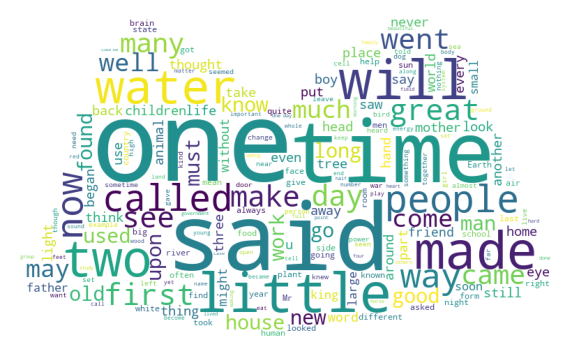

In [10]:
plt.figure(figsize=(10, 10))
text = df['excerpt'].values
url = 'https://static.vecteezy.com/system/resources/previews/000/263/280/non_2x/vector-open-book.jpg'
im = np.array(Image.open(requests.get(url, stream=True).raw))
cloud = WordCloud(stopwords = STOPWORDS,
                  background_color='white',
                  mask = im,
                  max_words = 200,
                  ).generate(" ".join(text))
plt.imshow(cloud)
plt.axis('off')
plt.show()

Then we can also plot the distribution of top part-of-speech tags of excerpt corpus. Part-Of-Speech Tagging (POS) is a process of assigning parts of speech to each word, such as noun, verb, adjective, etc.
For this we will use TextBlog to dive into POS of our "excerpt" data.

In [11]:
text = ' '.join(df['excerpt'])
blob = TextBlob(text)
top = Counter([pos[1] for pos in blob.tags])
df_temp = pd.DataFrame(top.most_common(15))
df_temp.columns = ['Part_of_Speech','count']
fig = px.bar(df_temp, x='Part_of_Speech', y='count', title='Top 15 Part-Of-Speech tagging', width=700,height=700, color='Part_of_Speech')
fig.show()

### **After that, now we will explore the data on the basis of complexity of the text.**

### **Number of words in each passage**

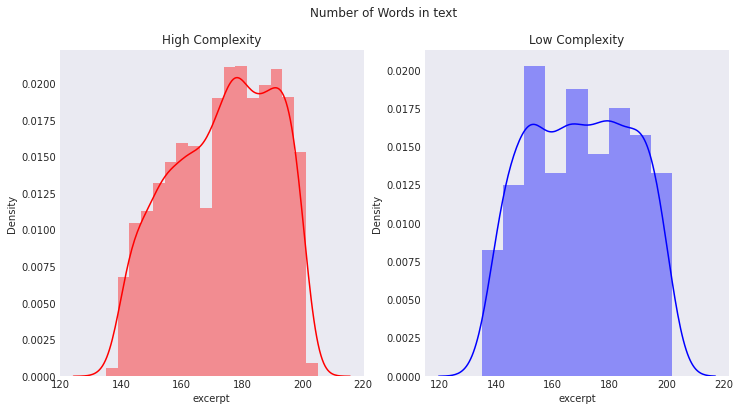

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

text_len = df[df['target'] <= 0]['excerpt'].str.split().map(lambda x: len(x))
sns.distplot(text_len, ax=ax[0], color='red')
ax[0].set_title('High Complexity')

text_len = df[df['target'] > 0]['excerpt'].str.split().map(lambda x: len(x))
sns.distplot(text_len, ax=ax[1], color='blue')
ax[1].set_title('Low Complexity')

fig.suptitle('Number of Words in text')
plt.show()

### **Average word length in each passage**

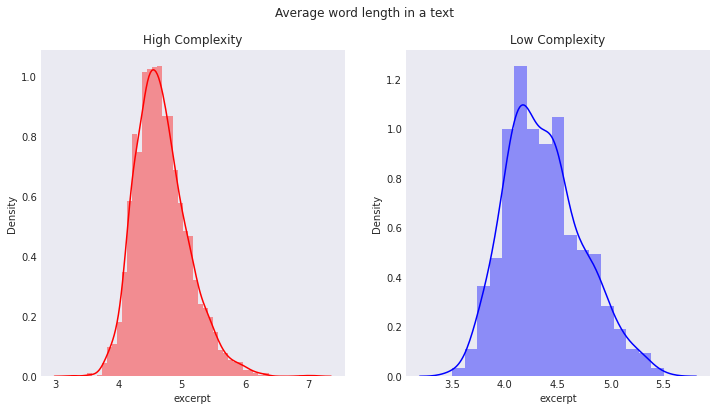

In [13]:
def avg_word_len(text):
    avg_len = text.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    return avg_len

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

avg_len = avg_word_len(df[df['target'] <= 0]['excerpt'])
sns.distplot(avg_len, ax=ax[0], color='red')
ax[0].set_title('High Complexity')

avg_len = avg_word_len(df[df['target'] > 0]['excerpt'])
sns.distplot(avg_len, ax=ax[1], color='blue')
ax[1].set_title('Low Complexity')

fig.suptitle('Average word length in a text')
plt.show()

### **Number of Sentences in text**

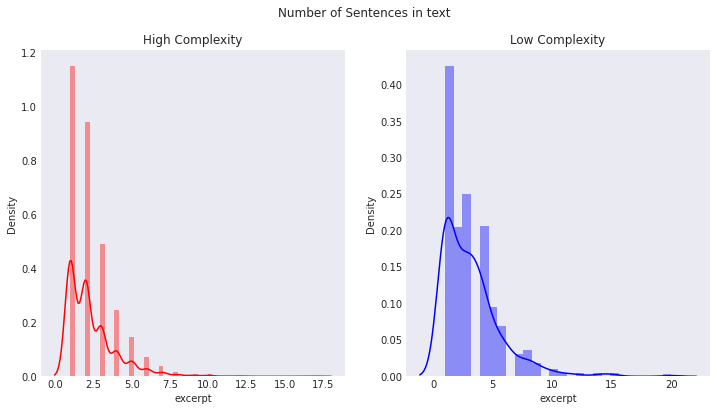

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

no_sents = df[df['target'] <= 0]['excerpt'].apply(lambda x : len(x.split('\n')))
sns.distplot(no_sents, ax=ax[0], color='red')
ax[0].set_title('High Complexity')

no_sents = df[df['target'] > 0]['excerpt'].apply(lambda x : len(x.split('\n')))
sns.distplot(no_sents, ax=ax[1], color='blue')
ax[1].set_title('Low Complexity')

fig.suptitle('Number of Sentences in text')
plt.show()

### **Now let us also compare these with the 'target'.**

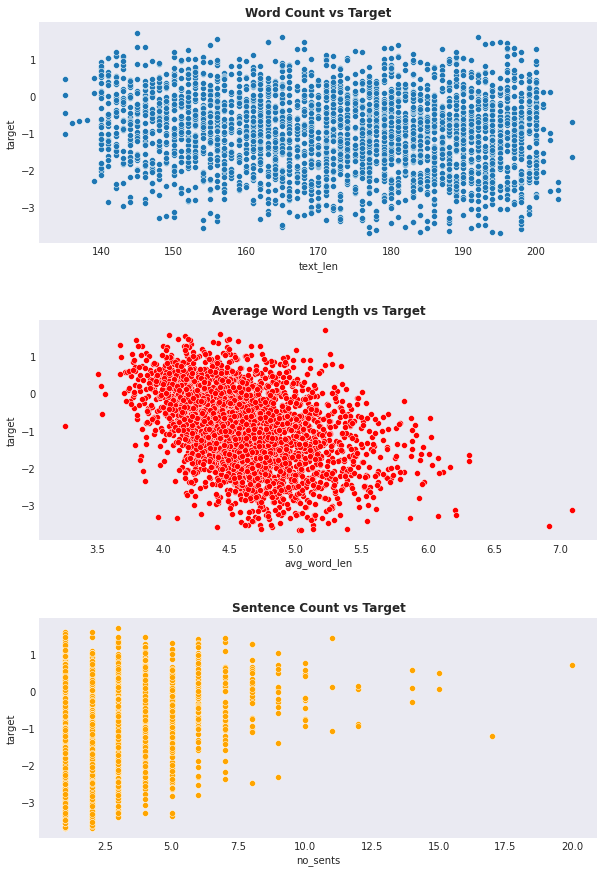

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(10,15))

df['text_len'] = df['excerpt'].str.split().map(lambda x: len(x))
sns.scatterplot(x='text_len', y='target', data=df, ax=ax[0])
ax[0].set_title("Word Count vs Target", fontweight ="bold")

avg_len = avg_word_len(df['excerpt'])
df['avg_word_len'] = avg_len
sns.scatterplot(x='avg_word_len', y='target', data=df, color='red', ax=ax[1])
ax[1].set_title("Average Word Length vs Target", fontweight ="bold")

df['no_sents'] = df['excerpt'].apply(lambda x : len(x.split('\n')))
sns.scatterplot(x='no_sents', y='target', data=df, color='orange', ax=ax[2])
ax[2].set_title("Sentence Count vs Target", fontweight ="bold")

plt.subplots_adjust(hspace=0.35)

plt.show()

### **Confusion Matrix**

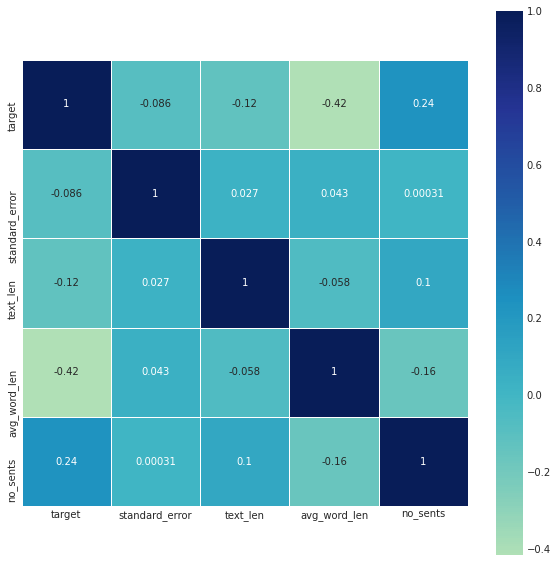

In [16]:
corr = df.corr()
fig = plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap="YlGnBu", center=0, square=True, linewidths=.5, annot=True)
plt.show()

<a id='4'></a>
# Data Preprocessing

In [17]:
wnl = WordNetLemmatizer()
def clean_text(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [wnl.lemmatize(word) for word in text if word not in stopwords.words('english')]
    text = " ".join(text)
    
    return text

In [18]:
df['clean_text'] = df['excerpt'].apply(lambda x : clean_text(x))

In [19]:
X = df['clean_text'].values
y = df['target'].values

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5)

After all the explorations and preprocessing now it's time to create some models. Firstly, we will build some different baseline machine learning models. I will be just creating some basic models so that you get to know how can use machine learning for nlp tasks. By using more features and some hyperparameter tuning, you can achieve better results also.

<a id='5'></a>
# ML Models (Baseline)

Before applying different kinds of ml algorithms, we first have to convert our string data into some numerical form(or vectorial form). So we can convert the text data into vector form through many ways. Here I will be using TF-IDF vectorizer.

In [21]:
tfidf = TfidfVectorizer(binary=True)
vect = tfidf.fit(X_train)
X_train = vect.transform(X_train)
X_val = vect.transform(X_val)

In [22]:
mse_plot = {} # For plotting purpose

<a id='5.1'></a>
## Linear Regression

In [23]:
model_lr = LinearRegression().fit(X_train, y_train)
y_pred = model_lr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mse_plot['LinearRegression'] = mse
print(f"Model Name: Linear Regression ====>>> MSE:{mse}")

Model Name: Linear Regression ====>>> MSE:0.6365169393005565


<a id='5.2'></a>
## Ridge Regression

In [24]:
model_rr = Ridge().fit(X_train, y_train)
y_pred = model_rr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mse_plot['RidgeRegression'] = mse
print(f"Model Name: Ridge Regression ====>>> MSE:{mse}")

Model Name: Ridge Regression ====>>> MSE:0.5738886419370776


<a id='5.3'></a>
## Support Vector Regression

In [25]:
model_svr = SVR().fit(X_train, y_train)
y_pred = model_svr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mse_plot['SVR'] = mse
print(f"Model Name: Support Vector Regression ====>>> MSE:{mse}")

Model Name: Support Vector Regression ====>>> MSE:0.6117194098437838


<a id='5.4'></a>
## Random Forest Regressor

In [26]:
model_rf = RandomForestRegressor().fit(X_train, y_train)
y_pred = model_rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mse_plot['RandomForest'] = mse
print(f"Model Name: Random Forest Regressor ====>>> MSE:{mse}")

Model Name: Random Forest Regressor ====>>> MSE:0.7320328591188371


<a id='5.5'></a>
## Gradient Boosting Regressor

In [27]:
model_gbr = GradientBoostingRegressor().fit(X_train, y_train)
y_pred = model_gbr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mse_plot['GradientBoosting'] = mse
print(f"Model Name: Gradient Boosting Regressor ====>>> MSE:{mse}")

Model Name: Gradient Boosting Regressor ====>>> MSE:0.690882150118664


<a id='5.6'></a>
## AdaBoost Regressor

In [28]:
model_abr = AdaBoostRegressor().fit(X_train, y_train)
y_pred = model_abr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mse_plot['AdaBoost'] = mse
print(f"Model Name: AdaBoost Regressor ====>>> MSE:{mse}")

Model Name: AdaBoost Regressor ====>>> MSE:0.8337046059173238


<a id='5.7'></a>
## XGBoost Regressor

In [29]:
model_xgb = XGBRegressor().fit(X_train, y_train)
y_pred = model_xgb.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mse_plot['XGBoost'] = mse
print(f"Model Name: XGBoost Regressor ====>>> MSE:{mse}")

Model Name: XGBoost Regressor ====>>> MSE:0.7297047504345371


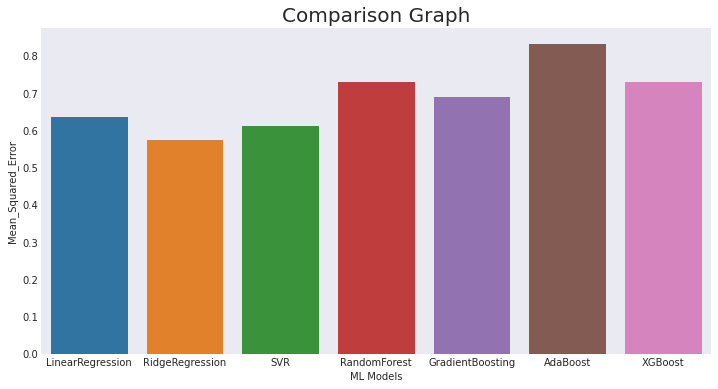

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(list(mse_plot.keys()), list(mse_plot.values()))
plt.xlabel("ML Models")
plt.ylabel("Mean_Squared_Error")
plt.title("Comparison Graph", fontsize=20)
plt.show()

<a id='6'></a>
# DL Models (Baseline)
Next, let us also talk about deep learning models. <br>
We will be using the same data which we got after applying data preprcoessing steps. But before creating the models we first have to process the data differently.<br>
Just as we converted our text data into vector form previously, here also we will convert our text data but using different technique.
Firstly, we will convert our data into one hot representation and for that we will be using keras Tokenizer. Then we will do padding i.e., we will make all the sentence length to be equal.

In [31]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [32]:
max_len = 512
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

In [33]:
X_train, X_val, y_train, y_val = train_test_split(padded, y, test_size=0.2, random_state=5)

<a id='6.1'></a>
## Simple RNN

In [34]:
model1 = Sequential()
model1.add(Embedding(len(word_index)+1, 250, input_length=max_len))
model1.add(SimpleRNN(100, return_sequences=True))
model1.add(SimpleRNN(100))
model1.add(Dense(100, activation='linear'))
model1.add(Dense(1, activation='linear'))

In [35]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 250)          5641750   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 512, 100)          35100     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 5,707,151
Trainable params: 5,707,151
Non-trainable params: 0
_________________________________________________________________


In [36]:
model1.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mse'])

In [37]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=5)

Epoch 1/5
71/71 [==============================] - 59s 805ms/step - loss: 1.2362 - mse: 1.2362 - val_loss: 1.1106 - val_mse: 1.1106
Epoch 2/5
71/71 [==============================] - 56s 791ms/step - loss: 1.0941 - mse: 1.0941 - val_loss: 1.1061 - val_mse: 1.1061
Epoch 3/5
71/71 [==============================] - 56s 792ms/step - loss: 1.1386 - mse: 1.1386 - val_loss: 1.1676 - val_mse: 1.1676
Epoch 4/5
71/71 [==============================] - 56s 788ms/step - loss: 1.0929 - mse: 1.0929 - val_loss: 1.1591 - val_mse: 1.1591
Epoch 5/5
71/71 [==============================] - 57s 799ms/step - loss: 1.0727 - mse: 1.0727 - val_loss: 1.1168 - val_mse: 1.1168


<a id='6.2'></a>
## LSTM

In [38]:
model2 = Sequential()
model2.add(Embedding(len(word_index)+1, 250, input_length=max_len))
model2.add(LSTM(100, return_sequences = True))
model2.add(LSTM(100))
model2.add(Dense(100, activation='linear'))
model2.add(Dense(1, activation='linear'))

In [39]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 250)          5641750   
_________________________________________________________________
lstm (LSTM)                  (None, 512, 100)          140400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 5,872,751
Trainable params: 5,872,751
Non-trainable params: 0
_________________________________________________________________


In [40]:
model2.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mse'])

model2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=5)

Epoch 1/5
71/71 [==============================] - 12s 115ms/step - loss: 1.2753 - mse: 1.2753 - val_loss: 1.1065 - val_mse: 1.1065
Epoch 2/5
71/71 [==============================] - 7s 105ms/step - loss: 1.0700 - mse: 1.0700 - val_loss: 1.1064 - val_mse: 1.1064
Epoch 3/5
71/71 [==============================] - 7s 103ms/step - loss: 1.0741 - mse: 1.0741 - val_loss: 1.1191 - val_mse: 1.1191
Epoch 4/5
71/71 [==============================] - 8s 109ms/step - loss: 1.0696 - mse: 1.0696 - val_loss: 1.1264 - val_mse: 1.1264
Epoch 5/5
71/71 [==============================] - 7s 105ms/step - loss: 1.0870 - mse: 1.0870 - val_loss: 1.1025 - val_mse: 1.1025


<a id='6.3'></a>
## Bidirectional RNN

In [41]:
model3 = Sequential()
model3.add(Embedding(len(word_index)+1, 250, input_length = max_len))
model3.add(Bidirectional(LSTM(100, return_sequences = True)))
model3.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model3.add(Dense(100, activation='linear'))
model3.add(Dense(1, activation='linear'))

In [42]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 512, 250)          5641750   
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 200)          280800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 6,183,551
Trainable params: 6,183,551
Non-trainable params: 0
_________________________________________________________________


In [43]:
model3.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mse'])

model3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=5)

Epoch 1/5
36/36 [==============================] - 155s 4s/step - loss: 1.2370 - mse: 1.2370 - val_loss: 0.7163 - val_mse: 0.7163
Epoch 2/5
36/36 [==============================] - 147s 4s/step - loss: 0.3191 - mse: 0.3191 - val_loss: 0.6779 - val_mse: 0.6779
Epoch 3/5
36/36 [==============================] - 147s 4s/step - loss: 0.1128 - mse: 0.1128 - val_loss: 0.6728 - val_mse: 0.6728
Epoch 4/5
36/36 [==============================] - 147s 4s/step - loss: 0.0555 - mse: 0.0555 - val_loss: 0.6810 - val_mse: 0.6810
Epoch 5/5
36/36 [==============================] - 149s 4s/step - loss: 0.0338 - mse: 0.0338 - val_loss: 0.6905 - val_mse: 0.6905


In [44]:
metrics1 = pd.DataFrame(model1.history.history)
metrics2 = pd.DataFrame(model2.history.history)
metrics3 = pd.DataFrame(model3.history.history)

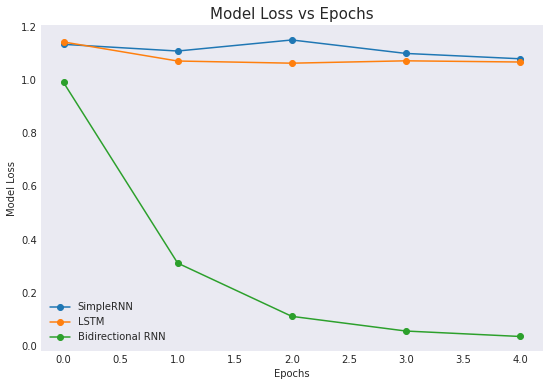

In [45]:
plt.figure(figsize=(9, 6))
metrics1['loss'].plot(label='SimpleRNN', marker='o')
metrics2['loss'].plot(label='LSTM', marker='o')
metrics3['loss'].plot(label='Bidirectional RNN', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Model Loss")
plt.title("Model Loss vs Epochs", fontsize=15)
plt.legend()
plt.show()

<a id='6.4'></a>
# BERT
Bidirectional Encoder Representations from Transformers (BERT) is a Transformer-based machine learning technique developed by Google. Before we see implementation of BERT, if you are a beginner and had never used BERT(I am also using BERT for the first time though😅), I would recommend you to go through the resources which I have listed below so that you know the basics and then implement BERT with a better understanding.

### Sequence To Sequence Models
* https://www.youtube.com/watch?v=jCrgzJlxTKg&list=PLZoTAELRMXVMdJ5sqbCK2LiM0HhQVWNzm&index=26&ab_channel=KrishNaik

### Attention Models
* https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a
* https://www.youtube.com/watch?v=fdhojC37_Co&list=PLZoTAELRMXVMdJ5sqbCK2LiM0HhQVWNzm&index=28&ab_channel=KrishNaik

### Transformers
* http://jalammar.github.io/illustrated-transformer/
* https://www.youtube.com/watch?v=SMZQrJ_L1vo&list=PLZoTAELRMXVMdJ5sqbCK2LiM0HhQVWNzm&index=29&ab_channel=KrishNaik

### BERT
* http://jalammar.github.io/illustrated-bert/
* https://www.youtube.com/watch?v=xI0HHN5XKDo&ab_channel=CodeEmporium

After going through all the resources, you will have a sound understanding of all the topics. So now its time to implement BERT. We will fine-tune our model for our task using TF/Keras.

**Reference :- [TF/Keras BERT Baseline (Training/Inference)](https://www.kaggle.com/jeongyoonlee/tf-keras-bert-baseline-training-inference/notebook)**

In [46]:
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import Model, Input, backend as K
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from transformers import TFBertModel, BertConfig, BertTokenizerFast
from tensorflow.keras.callbacks import LearningRateScheduler

### Tokenization using transformers

In [47]:
pretrained_dir = '../input/tfbert-base-uncased'

In [48]:
tokenizer = BertTokenizerFast.from_pretrained(pretrained_dir)

model_config = BertConfig.from_pretrained(pretrained_dir)
model_config.output_hidden_states = True

bert_model = TFBertModel.from_pretrained(pretrained_dir, config=model_config)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ../input/tfbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [49]:
def bert_encode(texts, tokenizer, max_len=max_len):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

In [50]:
X = bert_encode(X, tokenizer, max_len=max_len)

### Model Training 

In [51]:
def build_model(bert_model, max_len):
    input_ids = Input(shape=(max_len, ), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_len, ), dtype=tf.int32, name='attention_masks')
    token_type_ids = Input(shape=(max_len, ), dtype=tf.int32, name='token_type_ids')
    
    sequence_output = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
    output = sequence_output[:, 0, :]
    output = Dropout(0.2)(output)
    output = Dense(1, activation='linear')(output)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=output)
    model.compile(Adam(lr=1e-5), loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    
    return model

In [52]:
model = build_model(bert_model, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]        

In [53]:
def scheduler(epoch, lr, warmup=5, decay_start=10):
    if epoch <= warmup:
        return lr / (warmup - epoch + 1)
    elif warmup < epoch <= decay_start:
        return lr
    else:
        return lr * tf.math.exp(-.1)

ls = LearningRateScheduler(scheduler, verbose=1)

model.fit( X, y, validation_split=0.2, epochs=5, batch_size=8, callbacks=[ls])

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 1.6666666245631252e-06.
284/284 [==============================] - 191s 618ms/step - loss: 1.8016 - root_mean_squared_error: 1.2984 - val_loss: 0.4673 - val_root_mean_squared_error: 0.6836
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 3.3333333249174757e-07.
284/284 [==============================] - 173s 608ms/step - loss: 0.5524 - root_mean_squared_error: 0.7426 - val_loss: 0.4690 - val_root_mean_squared_error: 0.6848
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 8.333333312293689e-08.
284/284 [==============================] - 173s 608ms/step - loss: 0.4974 - root_mean_squared_error: 0.7045 - val_loss: 0.4757 - val_root_mean_squared_error: 0.6897
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 2.777777770764563e-08.
284/284 [==============================] - 173s 608ms/step - loss: 0.5322 - root_mean_squared_error: 0.7294 - val_loss: 0.4